In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

## 1) Dataset Size

In [2]:
scientific_domains = [
    "Genomics / Bioinformatics",
    "Physics / Astronomy",
    "Climate / Earth Science",
    "Neuroscience / Imaging",
    "Chemistry / Molecular Sim"
]

# Typical size ranges in TB (min, max)
dataset_sizes_tb = [
    (0.01, 1000),   # Genomics: 10 GB - 1 PB
    (1, 100000),    # Physics / Astronomy: 1 TB - 100 PB
    (0.01, 100),    # Climate / Earth Science: 10 GB - 100 TB
    (0.001, 10),    # Neuroscience / Imaging: 1 GB - 10 TB
    (0.1, 10)       # Chemistry / Molecular Simulation: 100 GB - 10 TB
]
avg_sizes = [np.mean(size) for size in dataset_sizes_tb]
plt.figure(figsize = (5,5))


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

Text(0.5, 0, 'Terabytes')

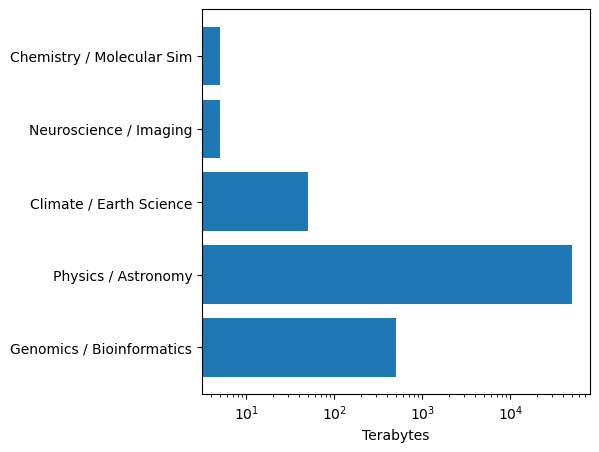

In [3]:
plt.figure(figsize=(5,5))
plt.barh(scientific_domains,avg_sizes)
plt.xscale("log")
plt.xlabel("Terabytes")

## 2) Bias vs. Variance trade-off

- Number of data points vs. Error.
- Model complexity vs. Error.

Make a model that runs a loop over a varying number of data points and a varying number of parameters. Fit for each version and then find the loss.

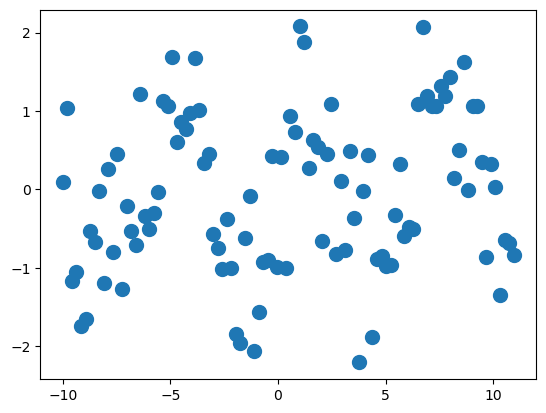

In [4]:
N_train = 100
sigma_train = 0.8
x =  np.linspace(-10,10.95,N_train)
s = sigma_train*np.random.randn(N_train)
y = np.sin(x) + s
plt.plot(x,y,'o',ms=10)

#### Fitting

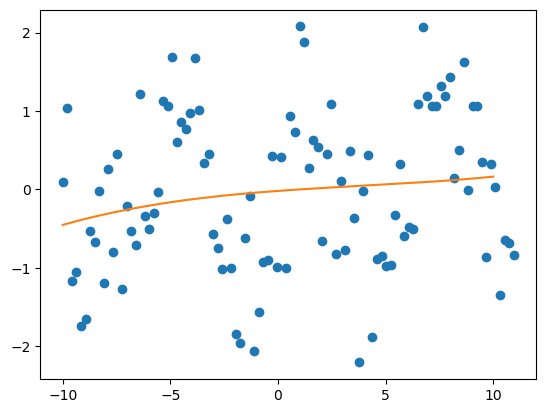

In [5]:
# plotting values
values = plt.plot(x,y,'o')



# plotting polynomial
poly3 = PolynomialFeatures(degree=3)
x = x.reshape(-1,1)
y = y.reshape(-1,1)
X = poly3.fit_transform(x)
clf3 = linear_model.LinearRegression()
clf3.fit(X,y)

xplot = np.linspace(-10,10,200).reshape(-1,1)
Xplot = poly3.fit_transform(xplot)
poly3_plot=plt.plot(xplot,clf3.predict(Xplot))


### Fitting it all together

In [6]:
def data_generation(num_dps):
    """Creates a set of x values, y values from the sine function and noisy y values to train on."""
    dps_arr = np.arange(1,1000,num_dps)
    stochastic_size = 0.7
    x =  np.linspace(-10,10,num_dps)
    s = stochastic_size*np.random.randn(num_dps)
    y_true = np.sin(x)
    y_noisy = np.sin(x) + s
    return x, y_true, y_noisy

def fitting_poly(x, y_noisy, num_params):
    x = x.reshape(-1,1)
    y_noisy = y_noisy.reshape(-1,1)
    poly = PolynomialFeatures(degree=num_params)
    X = poly.fit_transform(x)
    clf = linear_model.LinearRegression()
    clf.fit(X,y_noisy)
    return clf


def error_calc(clf, x, y_true, num_params):
    x = x.reshape(-1,1)
    y_true = y_true.reshape(-1,1)
    poly = PolynomialFeatures(degree=num_params)
    X = poly.fit_transform(x)
    y_prediction = clf.predict(X)
    error = mean_squared_error(y_true, y_prediction)
    return error

Text(0.5, 0, '')

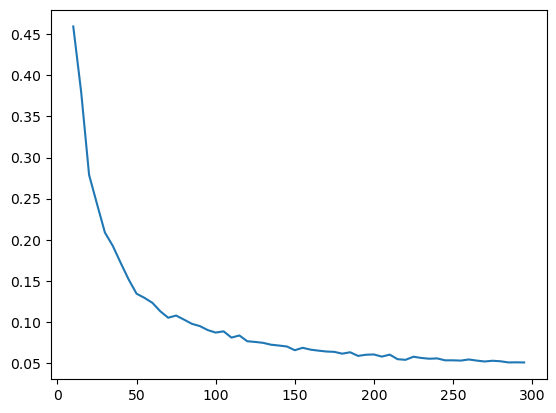

In [7]:
#initialising lists and stores
n_repeats = 100
n_parameters = np.logspace(0,2,dtype=int, num=10)
n_dpoints = np.arange(10,300,5)
error_param = np.zeros((n_parameters.shape[0],n_repeats))
error_data = np.zeros((n_dpoints.shape[0],n_repeats))


num_params = 10

for repeat_num in range(n_repeats):
    for i, num_dps in enumerate(n_dpoints):
        x, y_true, y_noisy = data_generation(num_dps)
        clf = fitting_poly(x, y_noisy, num_params)
        error_data[i,repeat_num] = error_calc(clf, x, y_true, num_params)

plt.plot(n_dpoints,np.mean(error_data,axis=1))
plt.xlabel('')

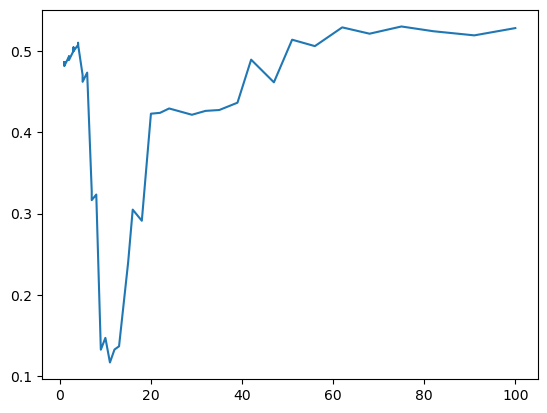

In [8]:
n_repeats = 100
n_parameters = np.logspace(0,2,dtype=int, num=50)
n_dpoints = np.arange(10,300,5)
error_param = np.zeros((n_parameters.shape[0],n_repeats))
error_data = np.zeros((n_dpoints.shape[0],n_repeats))

num_dps=50
for repeat_num in range(n_repeats):
    for i, num_params in enumerate(n_parameters):
        x, y_true, y_noisy = data_generation(num_dps)
        clf = fitting_poly(x, y_noisy, num_params)
        error_param[i,repeat_num] = error_calc(clf, x, y_true, num_params)

plt.plot(n_parameters,np.mean(error_param, axis=1))

## 3) Gradient Descent

In [12]:
#creating grid
n = 100
X = np.linspace(-10.5,10.5,n),
Y = np.linspace(-4.5,4.5,n)
x, y = np.meshgrid(X,Y)

def beales_function(x, y):
    """Takes in scalar or arrays of x and y, and uses them to calcualte the givem target function"""
    a = (1.5 - x + (x*y))**2
    b = (2.25 - x + (x*y*y))**2
    c = (2.625 - x + (x*y*y*y))**2
    return a + b + c
    
def beales_grad(params):
    """Retursn the gradient of the beales function at any x, y value.
    params: [[x_value, y_value]]"""
    x = params[0]
    y= params[1]
    grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
    grad_y=2*(1.5-x+x*y)*x+4*(2.25-x+x*y**2)*x*y+6*(2.625-x+x*y**3)*x*y**2

    return np.array([grad_x, grad_y])

def update_ADAM(n_epochs, params, beta1, beta2, eta, epsilon):
    #initialising moments\
    params_traj = np.zeros((2,n_epochs+1))
    params_traj[:,0] = params
    moment1 = 0 #this acts like momentum, smoothing gradient direction over time
    moment2 = 0 #this is the variance of the gradients, tracks the magnitured (grad^2) of each parameter over time
    
    for i in range(n_epochs):
        #time step number here is (i+1)
        grads = beales_grad(params)
        moment1 = beta1*moment1 + (1 - beta1)*grads
        moment2 = beta2*moment2 + (1 -  beta2)*np.square(grads)

        #correcting bias ensuring early iterations arent artificially small
        moment1_cor = moment1/(1-beta1**(i+1))
        moment2_cor = moment2/(1-beta2**(i+1))
        params = params - eta*(moment1_cor/(np.sqrt(moment2_cor)+epsilon))
        
        params_traj[:,i+1] = params
    return params_traj

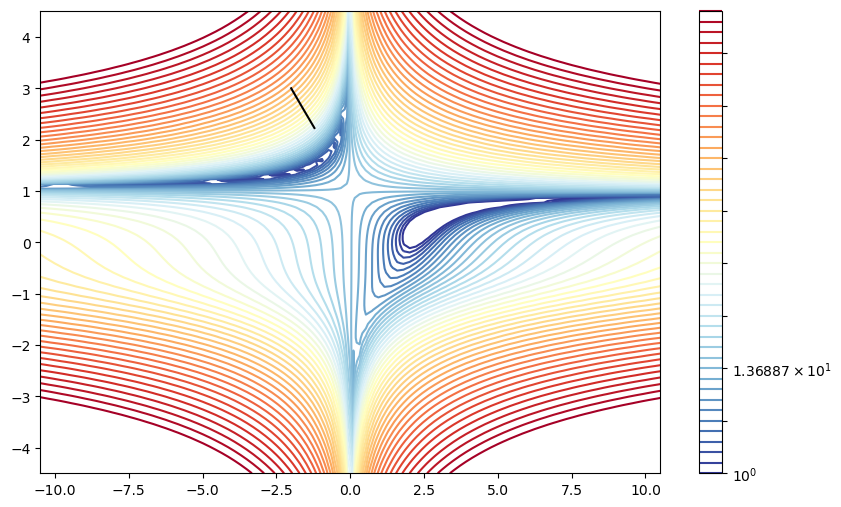

[[-2.         -1.999      -1.99800006 ... -1.21422373 -1.21353276
  -1.21284197]
 [ 3.          2.999       2.99800007 ...  2.22768595  2.22701564
   2.22634552]]


In [20]:
#intialising optimisation
n_epochs = 1000
params = np.array([-2,3]) #start point
beta1 = 0.9 #controls how much past gradients influence momentum
beta2 = 0.99 # controls how much past squared gradients influence adaptive step size
eta = 0.001
epsilon = 10e-8

#running function
params_traj = update_ADAM(n_epochs, params, beta1, beta2, eta, epsilon)

f_xy = beales_function(x,y)
plt.figure(figsize=(10,6))
plt.contour(x, y, f_xy, extent=[x.min(), x.max(), y.min(), y.max()], norm=LogNorm(), levels = np.logspace(0, 5, 45), cmap="RdYlBu_r")
plt.plot(params_traj[0,:],params_traj[1,:], color='black')
plt.colorbar()
plt.show()
print(params_traj)

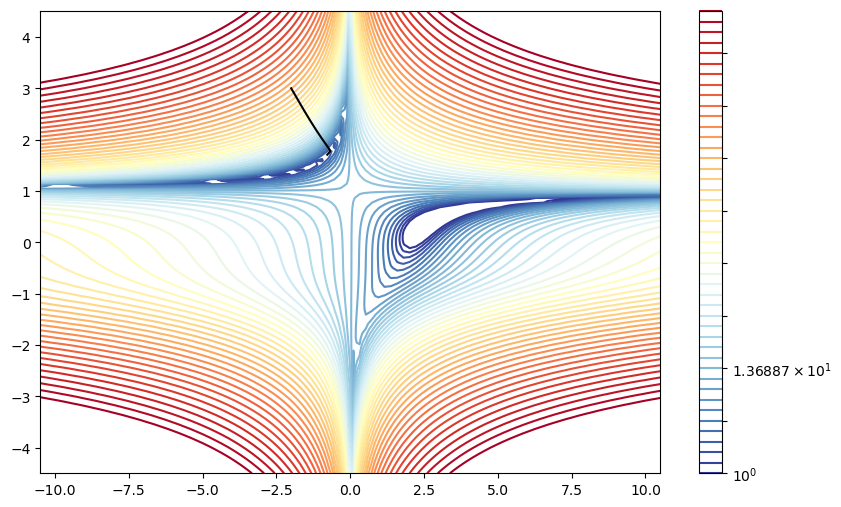

[[-2.         -1.99       -1.98000711 ... -0.77663997 -0.77726126
  -0.77788561]
 [ 3.          2.99        2.98000753 ...  1.70675345  1.70637967
   1.7060045 ]]


In [19]:
#intialising optimisation
n_epochs = 1000
params = np.array([-2,3]) #start point
beta1 = 0.9
beta2 = 0.99
eta = 10e-3
epsilon = 10e-8

#running function
params_traj = update_ADAM(n_epochs, params, beta1, beta2, eta, epsilon)

f_xy = beales_function(x,y)
plt.figure(figsize=(10,6))
plt.contour(x, y, f_xy, extent=[x.min(), x.max(), y.min(), y.max()], norm=LogNorm(), levels = np.logspace(0, 5, 45), cmap="RdYlBu_r")
plt.plot(params_traj[0,:],params_traj[1,:], color='black')
plt.colorbar()
plt.show()
print(params_traj)